In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

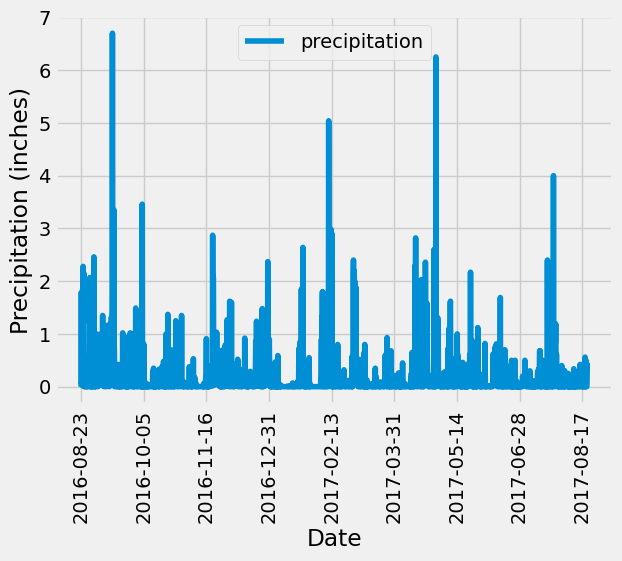

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
recent_date_as_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
recent_date_as_date = recent_date_as_date.date()

one_year = recent_date_as_date - dt.timedelta(days=365)
one_year_string = one_year.strftime('%Y-%m-%d')


precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date <= recent_date[0]).\
                        filter(Measurement.date >= one_year_string).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = "date").dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot = 90, xlabel = 'Date', ylabel = 'Precipitation (inches)')
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_number = 'USC00519281'
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

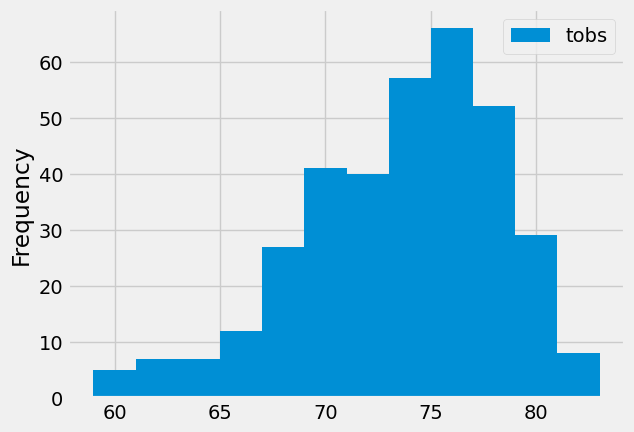

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Choose the station with the highest number of temperature observations.
station_highest_observations = active_stations[0][0]

results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == station_highest_observations).all()

# convert to dataframe
results_df = pd.DataFrame(results)

# historgram 
results_df.plot.hist(bins=12)

# Close Session

In [34]:
# Close Session
session.close()